# Aspect Based Sentiment Analysis

#### Author: Pratyush Bagaria (pbagar2@uic.edu, pratyush_bagaria@hotmail.com)

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_predict

#### A. Reading Data Files (both train and test)

In [2]:
datafile_train = pd.read_csv("data_train.csv")
text_train = datafile_train.text
aspect_terms_train = datafile_train.aspect_term
labels_train = datafile_train['class']
datafile_train.head()

,example_id,text,aspect_term,term_location,class
0,2333_1,Obviously one of the most important features o...,human interface,69--84,0
1,1805_1,Good for every day computing and web browsing.,every day computing,9--28,1
2,2782_2,while the keyboard itself is alright[comma] th...,mouse command buttons,115--136,-1
3,1385_0,Again[comma] the same problem[comma] the right...,right speaker,29--42,-1
4,1423_0,My problem was with DELL Customer Service.,DELL Customer Service,20--41,-1


In [3]:
datafile_test = pd.read_csv("data_test.csv")
text_test = datafile_test.text
aspect_terms_test = datafile_test.aspect_term
term_location_test = datafile_test.term_location
datafile_test.head()

,example_id,text,aspect_term,term_location
0,494:1_0,Buy the separate RAM memory and you will have ...,RAM memory,17--27
1,311:18_1,But with this laptop[comma] the bass is very w...,sound,52--57
2,256:1_0,This hardware seems to be better than the iMac...,hardware,5--13
3,748:1_0,It is very easy to navigate even for a novice.,navigate,19--27
4,128:1_0,Amazing Performance for anything I throw at it.,Performance,8--19


#### B. Preprocessing Data and Feature Extraction

In [4]:
bigram_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer = 'word')
en_stopwords = stopwords.words('english')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
window_size = 5

In [5]:
def preprocessData(text,aspect_terms):
    cleaned_text = []
    def cleanText(t):
        for i in range(len(t)):
            sentence = t[i]
            sentence = sentence.replace("[comma]", ",")
            sentence = ' '.join(sentence.split())
            sentence = re.sub('[^a-zA-Z0-9 \n\.]', '', sentence)
            sentence = sentence.lower()
            sentence = str([word for word in sentence.split() if word not in en_stopwords])
            sentence = tokenizer.tokenize(sentence)
            cleaned_text.append(sentence)
        return cleaned_text
    cleaned_text = cleanText(text)
    cleaned_text = [" ".join(t) for t in cleaned_text]
    
    final_text = []
    for t, aspect_term in zip(cleaned_text,aspect_terms):
        #print ("here")
        #print (t, "APPPPP", aspect_term)
        firstIndex,lastIndex=0,0
        temp_text=[]
        t = t.replace(' '.join(aspect_term.split()).lower(),"***")
        t = t.split()
        if " ".join(t).count("***")==0:
            for k in range(0,len(t)):
                temp_text.append(t[k])
        elif " ".join(t).count("***")==1:
            for index, word in enumerate(t):
                    if word == "***":
                        start = index - window_size if index>=window_size else 0
                        stop = index + window_size + 1 if index + window_size + 1<=len(t) else len(t)
                        for k in range(start,stop):
                            temp_text.append(t[k])
        elif " ".join(t).count("***")>1:
            start = t.index("***") - window_size if t.index("***")>=window_size else 0
            stop = len(t)-1-t[::-1].index("***")+window_size+1 if len(t)-1-t[::-1].index("***")+window_size+1<=len(t) else len(t)
            for k in range(start,stop):
                temp_text.append(t[k])

        temp_text = " ".join(temp_text)
        temp_text = temp_text.replace("***",' '.join(aspect_term.split()).lower())
        final_text.append(temp_text)
    return (final_text)

In [6]:
X_train = preprocessData(text_train,aspect_terms_train)
X_train = bigram_vectorizer.fit_transform(X_train)

In [7]:
X_test = preprocessData(text_test,aspect_terms_test)
X_test = bigram_vectorizer.transform(X_test)

#### C. Training

In [8]:
#X1 implies training samples (texts) obtained from X_train dataset
#X2 implies test samples (texts) obtained from X_train dataset
#Y1 implies training samples (labels) obtained from X_train dataset
#Y2 implies test samples (labels) obtained from X_train dataset

X1, X2, Y1, Y2 = train_test_split(X_train, labels_train, test_size=0.25)

dt = tree.DecisionTreeClassifier()
svc = SVC(kernel='linear')
nb = MultinomialNB(fit_prior=False, alpha=0.25)
rf = RandomForestClassifier(n_estimators=10)
mlpc = MLPClassifier()
classifiers = [dt, svc, nb, rf, mlpc]
model = ["Linear SVM","Multinomial Naive Bayes","Decision Tree","Random Forest","Multi-Layer Perceptron Classifier"]
model_accuracy = []
i=0
for classifier in classifiers:
    print ("***********************************************************")
    print("Training for "+str(model[i]))
    yPred = cross_val_predict(classifier, X1, list(Y1), cv=10)
    print(classification_report(list(Y1), yPred))
    model_accuracy.append(round(accuracy_score(list(Y1), yPred),2))
    print("Overall accuracy for", model[i], "is :", model_accuracy[i])
    i+=1
    classifier.fit(X1,Y1)
    print ("***********************************************************")

print ("Highest accuracy obtained is:", max(model_accuracy))
print ("Model corresponding to this accuracy is:", model[model_accuracy.index(max(model_accuracy))])

***********************************************************
Training for Linear SVM
              precision    recall  f1-score   support

          -1       0.64      0.74      0.69       635
           0       0.51      0.41      0.45       322
           1       0.77      0.73      0.75       695

   micro avg       0.67      0.67      0.67      1652
   macro avg       0.64      0.63      0.63      1652
weighted avg       0.67      0.67      0.67      1652

Overall accuracy for Linear SVM is : 0.67
***********************************************************
***********************************************************
Training for Multinomial Naive Bayes
              precision    recall  f1-score   support

          -1       0.70      0.79      0.74       635
           0       0.55      0.47      0.51       322
           1       0.80      0.76      0.78       695

   micro avg       0.72      0.72      0.72      1652
   macro avg       0.68      0.67      0.68      1652
weighted a

#### D. Predicting

In [9]:
clf = classifiers[model_accuracy.index(max(model_accuracy))]
clf.fit(X_train, labels_train)
labels_predicted = clf.predict(X_test)

#### E. Plot Graphs and Write Output files

In [38]:
def writeOutputTextFile(labels_predicted):
    outputfile = open('data_output.txt','a')
    id = datafile_test.example_id
    for i in range(len(datafile_test['example_id'])):
        outputfile.write(str(id[i])+";;"+str(labels_predicted[i])+'\n')
    outputfile.close()

In [39]:
def plotGraph(labels_predicted):
    countList = [labels_predicted.tolist().count(1), labels_predicted.tolist().count(0), labels_predicted.tolist().count(-1)]
    pos, neu, neg = plt.bar([1,0,-1],countList)
    plt.xticks([-1,0,1],[labels_predicted.tolist().count(-1),labels_predicted.tolist().count(0),labels_predicted.tolist().count(1)])
    pos.set_facecolor('green')
    neu.set_facecolor('yellow')
    neg.set_facecolor('red')
    pos.set_label('Positive Class')
    neu.set_label('Neutral Class')
    neg.set_label('Negative Class')
    plt.legend(bbox_to_anchor=(1,1), loc='best', title="Legends\n")
    plt.ylabel("Count of Predicted Labels")
    plt.show()

Class labels for test datatest is predicted using Multinomial Naive Bayes


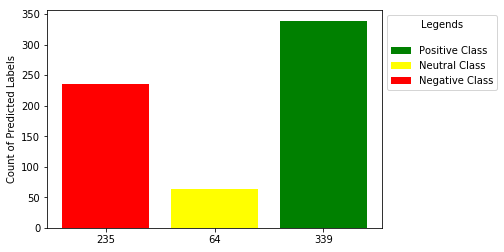

In [41]:
print ("Class labels for test datatest is predicted using " + model[model_accuracy.index(max(model_accuracy))])
writeOutputTextFile(labels_predicted.tolist())
plotGraph(labels_predicted)